# Gradient-free `CRP` parameter optimization

In [1]:
import pennylane as qml
from pennylane import numpy as np
from numpy.typing import NDArray

from matplotlib import pyplot as plt

## 1. Set up demo circuit

In [2]:
from circuits import sim_03

num_layers = 5
num_qubits = 4
circuit = sim_03(num_layers, num_qubits)

print(qml.draw(circuit)(np.random.random((num_layers, num_qubits, 3))))

0: ──RX(0.80)──RZ(0.78)─────────────────────╭RZ(0.35)──RX(0.68)──RZ(0.85)───────────╭RZ(0.35)
1: ──RX(0.81)──RZ(0.11)───────────╭RZ(0.81)─╰●─────────RX(0.54)──RZ(0.31)─╭RZ(0.94)─╰●───────
2: ──RX(0.26)──RZ(0.45)─╭RZ(0.51)─╰●─────────RX(0.99)──RZ(0.29)─╭RZ(0.18)─╰●─────────RX(0.14)
3: ──RX(0.02)──RZ(0.10)─╰●─────────RX(0.24)──RZ(0.99)───────────╰●─────────RX(0.86)──RZ(0.12)

───RX(0.49)──RZ(0.40)───────────╭RZ(0.70)──RX(0.98)──RZ(0.92)───────────╭RZ(0.04)──RX(0.83)
───RX(0.46)──RZ(0.84)─╭RZ(0.96)─╰●─────────RX(0.12)──RZ(0.85)─╭RZ(0.34)─╰●─────────RX(0.50)
───RZ(0.87)─╭RZ(0.63)─╰●─────────RX(0.91)──RZ(0.03)─╭RZ(0.63)─╰●─────────RX(0.70)──RZ(0.28)
────────────╰●─────────RX(0.04)──RZ(0.29)───────────╰●─────────RX(0.88)──RZ(0.42)──────────

───RZ(0.07)───────────╭RZ(0.04)─┤     
───RZ(0.45)─╭RZ(0.98)─╰●────────┤  <Z>
──╭RZ(0.21)─╰●──────────────────┤     
──╰●────────────────────────────┤     


## 2. Optimization loop

In [6]:
from CrotosolveOptimizer import CrotosolveOptimizer

def crotosolve(circuit, initial_params, debug = False):
    optimizer = CrotosolveOptimizer()
    iterations_dataset = [circuit(initial_params)]
    updates_dataset = [circuit(initial_params)]

    params = initial_params.copy()
    for iteration in range(5):
        if debug: print(f" ===== ITERATION NO {iteration} =====")
        new_fun_value = optimizer.step_and_cost(circuit, params, updates_dataset, debug=debug)
        iterations_dataset.append(new_fun_value)
    
    return params, iterations_dataset, updates_dataset

rng = np.random.default_rng()
params = rng.random((5, 4, 3))

final_params, iterations_dataset, updates_dataset = crotosolve(circuit, params, debug=True)

 ===== ITERATION NO 0 =====
Optimizing parameter (0, 0, 0)...
Parameter update for (0, 0, 0) from 0.7804946555240337 to 6.199832698984249 (0.3210868270458873)
Optimizing parameter (0, 0, 1)...
Parameter update for (0, 0, 1) from 0.699463801252713 to 5.469967238012803 (0.2994476227773426)
Optimizing parameter (0, 0, 2)...
Parameter update for (0, 0, 2) from 0.8065833251179226 to 3.3211324647262828 (0.06725043358243415)
Optimizing parameter (0, 1, 0)...
Parameter update for (0, 1, 0) from 0.6494479649997742 to 2.0766210850779014 (-0.46928877754453047)
Optimizing parameter (0, 1, 1)...
Parameter update for (0, 1, 1) from 0.3903682222234304 to 6.656141756790307 (-0.46936141791568986)
Optimizing parameter (0, 1, 2)...
Parameter update for (0, 1, 2) from 0.9508995363453174 to 8.761451808729614 (-0.7562088884989508)
Optimizing parameter (0, 2, 0)...
Parameter update for (0, 2, 0) from 0.7804186883876603 to 6.999843882367076 (-0.7574361400636539)
Optimizing parameter (0, 2, 1)...
Parameter upd

## 3. Print charts

Text(0.5, 1.0, 'Loss curve over crotosolve iterations')

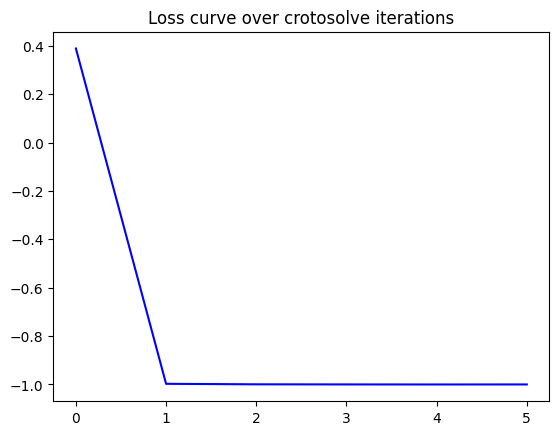

In [7]:

fig, ax = plt.subplots()
ax.plot(range(len(iterations_dataset)), iterations_dataset, 'b')
ax.set_title("Loss curve over crotosolve iterations")

Text(0.5, 1.0, 'Loss curve over circuit evaluations')

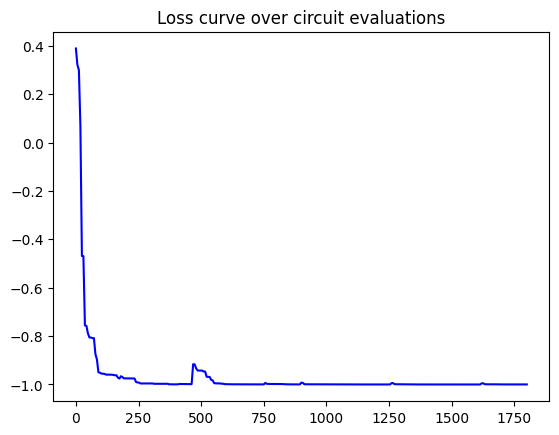

In [8]:

fig, ax = plt.subplots()
# multiply num of updates by 6 to get number of evaluations
ax.plot(6 * np.array(range(len(updates_dataset))), updates_dataset, 'b')
ax.set_title("Loss curve over circuit evaluations")